# Ch. 1 Exploring High Dimensional Data
## Why reduce dimensionality?
- less complex
- requires less disk space
- requires less computation time
- have a lower chance of a model overfitting

## TSNE

In [1]:
import pandas as pd
df = pd.read_csv('ansur_female.txt')

# Drop non-numeric features
non_numeric = ['BMI_class', 'Height_class', 'Gender', 'Component', 'Branch']
df_numeric = df.drop(non_numeric, axis=1)

df_numeric.shape

(1986, 94)

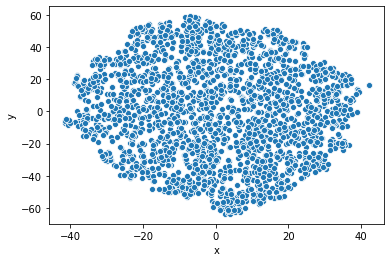

In [2]:
from sklearn.manifold import TSNE
m = TSNE(learning_rate=50)

# Fit and transform TSNE model to numeric data set
tsne_features = m.fit_transform(df_numeric)

# Assign TSNE features back to original dataset as new columns
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

# Plot the TSNE results
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='x', y='y', data=df)
plt.show()

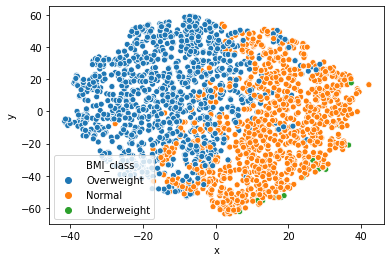

In [3]:
# Check if categorical features can show clusters
sns.scatterplot(x='x', y='y', hue='BMI_class', data=df)
plt.show()

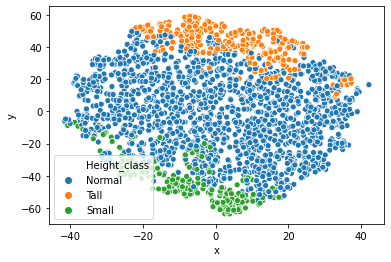

In [4]:
sns.scatterplot(x='x', y='y', hue='Height_class', data=df)
plt.show()

# Ch. 2 Feature selection I, selecting for feature information
## Creating a Feature Selector

In [5]:
# Load data
df = pd.read_csv('ansur.csv')

# Drop non-numeric features
non_numeric = ['BMI_class', 'Height_class', 'Gender', 'Component', 'Branch']
ansur = df.drop(non_numeric, axis=1)

ansur.shape

(6068, 94)

### Using a variance threshold selector

In [6]:
# Imports
from sklearn.feature_selection import VarianceThreshold

# Instantiate and fit feature selector
sel = VarianceThreshold(threshold=1)
sel.fit(ansur)

# Assign a mask variable to use in feature selection
mask = sel.get_support() # True/False if feature variance is above the threshold set

# Use Mask to select columns with true values
reduced_ansur = ansur.loc[:,mask]

# Assess shape of reduced dataframe
print(reduced_ansur.shape)

(6068, 93)


Only one feature was dropped. This is because variance can have very different magnitudes across different features. We should normalize the variance before using it as a feature selector

In [7]:
# Imports
from sklearn.feature_selection import VarianceThreshold

# Instantiate and fit feature selector
sel = VarianceThreshold(threshold=0.005) # Threshold needs to be determined by inspecting dataset
sel.fit(ansur/ansur.mean())

# Assign a mask variable to use in feature selection
mask = sel.get_support() # True/False if feature variance is above the threshold set

# Use Mask to select columns with true values
reduced_ansur = ansur.loc[:,mask]

# Assess shape of reduced dataframe
print(reduced_ansur.shape)

(6068, 45)


### Correlation Matrix and Visualizing

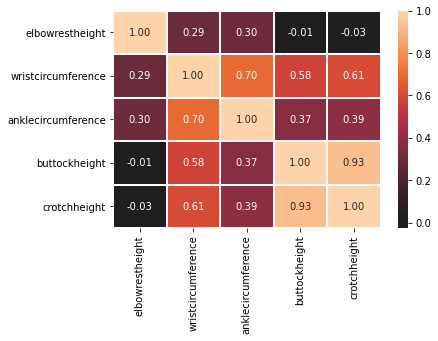

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

body = ['elbowrestheight', 'wristcircumference', 'anklecircumference', 'buttockheight', 'crotchheight']
ansur_df = ansur[body]

# Create the correlation matrix
corr = ansur_df.corr()

# Draw the heatmap
sns.heatmap(corr, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

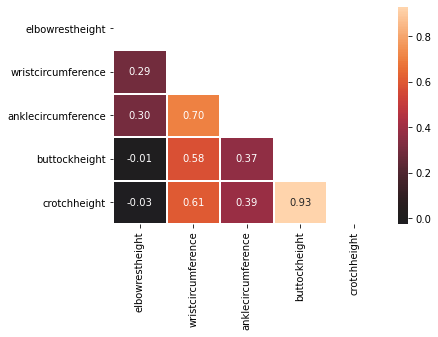

In [9]:
# Create the correlation matrix
corr = ansur_df.corr()

# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr, dtype=bool))

# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

### Removing highly correlated values

In [10]:
# Create a positive correlation matrix
corr_df = ansur.corr().abs()

# Create and apply mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)

# Find columns that exceed correlation threshold
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.95)]

# Drop selected features
reduced_ansur = ansur.drop(to_drop, axis=1)

print(ansur.shape)
print(reduced_ansur.shape)

(6068, 94)
(6068, 75)


# Ch. 3 Feature selection II, selecting for model accuracy
## Recursive Feature Elimination (RFE)
- can be used on models that assign feature importance or coefficients
- fits the initial model and removes the feature with the lowest coefficient. Then fits the model again with the remaining features and removes the lowest coeff again. Repeats until specified number of features are left
- pass the model to use and the number of features to select

Steps
- from sklearn.feature_selection import RFE
- rfe = RFE(estimator=LogisticRegression(), n_features_to_select=2, verbose=1)
- rfe.fit(X_train, y_train)

Tools
- rfe.support_ gives true/false on if a feature was kept. 
- X.columns[rfe.support_] will show a list of kept columns
- print(dict(zip(X.columns, rfe.ranking_))) will print all features with the ranking of importance based on which iteration it was removed in

In [19]:
# Imports
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
SEED = 830

# Load and split data
diabetes = pd.read_csv('diabetes.csv')
y = diabetes.test
X = diabetes.drop('test', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state= SEED)

# Instantiate and create
scaler = StandardScaler()
lr = LogisticRegression()

# Fit the scaler on the training features and transform these in one go
X_train_std = scaler.fit_transform(X_train)

# Fit the logistic regression model on the scaled training data
lr.fit(X_train_std, y_train)

# Scale the test features
X_test_std = scaler.transform(X_test)

# Predict diabetes presence on the scaled test set
y_pred = lr.predict(X_test_std)

# Prints accuracy metrics and feature coefficients
print("{0:.1%} accuracy on test set.".format(accuracy_score(y_test, y_pred))) 
print(dict(zip(X.columns, abs(lr.coef_[0]).round(2))))

79.6% accuracy on test set.
{'pregnant': 0.07, 'glucose': 1.22, 'diastolic': 0.04, 'triceps': 0.22, 'insulin': 0.1, 'bmi': 0.41, 'family': 0.25, 'age': 0.41}


In [22]:
# Create the RFE with a LogisticRegression estimator and 3 features to select
rfe = RFE(estimator=lr, n_features_to_select=3, verbose=1)

# Fits the eliminator to the data
rfe.fit(X_train, y_train)

# Print the features and their ranking (high = dropped early on)
print(dict(zip(X.columns, rfe.ranking_)))

# Print the features that are not eliminated
print(X.columns[rfe.support_])

# Calculates the test set accuracy
acc = accuracy_score(y_test, rfe.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
{'pregnant': 4, 'glucose': 2, 'diastolic': 5, 'triceps': 3, 'insulin': 6, 'bmi': 1, 'family': 1, 'age': 1}
Index(['bmi', 'family', 'age'], dtype='object')
76.5% accuracy on test set.


C:\Users\16084\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Tree-based Feature Selection

In [26]:
# Imports
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
SEED = 830

# Load and split data
diabetes = pd.read_csv('diabetes.csv')
y = diabetes.test
X = diabetes.drop('test', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state= 0)

# Perform a 75% training and 25% test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=SEED)

# Fit the random forest model to the training data
rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train, y_train)

# Calculate the accuracy
acc = accuracy_score(y_test, rf.predict(X_test))

# Print the importances per feature
print(dict(zip(X.columns, rf.feature_importances_.round(2))))

# Print accuracy
print("{0:.1%} accuracy on test set.".format(acc))

{'pregnant': 0.07, 'glucose': 0.26, 'diastolic': 0.08, 'triceps': 0.1, 'insulin': 0.16, 'bmi': 0.11, 'family': 0.1, 'age': 0.13}
78.6% accuracy on test set.


#### Creating a mask with feature importance values from RandomForestsClassifier

In [27]:
# Create a mask for features importances above the threshold
mask = rf.feature_importances_ > 0.15

# Apply the mask to the feature dataset X
reduced_X = X.loc[:,mask]

# prints out the selected column names
print(reduced_X.columns)

Index(['glucose', 'insulin'], dtype='object')


#### Wrapping RandomForests inside an RFE

In [28]:
# Set the feature eliminator to remove 2 features on each step
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=2, step=2, verbose=1)

# Fit the model to the training data
rfe.fit(X_train, y_train)

# Create a mask
mask = rfe.support_

# Apply the mask to the feature dataset X and print the result
reduced_X = X.loc[:, mask]
print(reduced_X.columns)

Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Index(['glucose', 'insulin'], dtype='object')


## Regularized Linear Regression
#### Prepare data

In [100]:
# Imports
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
SEED = 830

# Load the data
df = pd.read_csv('ansur.csv')

# Drop non-numeric features
non_numeric = ['BMI_class', 'Height_class', 'Gender', 'Component', 'Branch']
ansur = df.drop(non_numeric, axis=1)

# Assign target and predictors
y = ansur.BMI
X = ansur.drop('BMI', axis=1)

# Scale the predictors
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=.25, random_state= SEED)

#### Fit the model and evaluate

In [90]:
# Instantiate the model
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = .01)

# Fit the scaler on the training features and transform these in one go
X_train_std = scaler.fit_transform(X_train)

# Fit it to the standardized training data
lasso.fit(X_train_std, y_train)

# Transform the test set with the pre-fitted scaler
X_test_std = scaler.transform(X_test)

# Calculate the coefficient of determination (R squared) on X_test_std
r_squared = lasso.score(X_test_std, y_test)
print("The model can predict {0:.1%} of the variance in the test set.".format(r_squared))

# Create a list that has True values when coefficients equal 0
zero_coef = lasso.coef_ == 0

# Calculate how many features have a zero coefficient
n_ignored = sum(zero_coef)
print("The model has ignored {} out of {} features.".format(n_ignored, len(lasso.coef_)))

The model can predict 99.3% of the variance in the test set.
The model has ignored 50 out of 93 features.


## Combining Feature Selectors
using data prepared above

In [91]:
from sklearn.linear_model import LassoCV

# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train, y_train)
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

# Calculate R squared on the test set
r_squared = lcv.score(X_test, y_test)
print('The model explains {0:.1%} of the test set variance'.format(r_squared))

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))

Optimal alpha = 0.004
The model explains 99.4% of the test set variance
55 features out of 93 selected


C:\Users\16084\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.988069608278408, tolerance: 7.281928936217169
  model = cd_fast.enet_coordinate_descent(


In [92]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

# Select 10 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=10, step=10, verbose=1)
rfe_gb.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

Fitting estimator with 93 features.
Fitting estimator with 83 features.
Fitting estimator with 73 features.
Fitting estimator with 63 features.
Fitting estimator with 53 features.
Fitting estimator with 43 features.
Fitting estimator with 33 features.
Fitting estimator with 23 features.
Fitting estimator with 13 features.
The model can explain 97.3% of the variance in the test set


In [101]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Select 10 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(), 
             n_features_to_select=10, step=10, verbose=1)
rfe_rf.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
rf_mask = rfe_rf.support_

Fitting estimator with 93 features.
Fitting estimator with 83 features.
Fitting estimator with 73 features.
Fitting estimator with 63 features.
Fitting estimator with 53 features.
Fitting estimator with 43 features.
Fitting estimator with 33 features.
Fitting estimator with 23 features.
Fitting estimator with 13 features.
The model can explain 97.6% of the variance in the test set


In [102]:
# Sum the votes of the three models
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)

# Create a mask for features selected by all 3 models
meta_mask = votes >= 3

# Apply the dimensionality reduction on X
X_reduced = X.loc[:, meta_mask]

# Plug the reduced dataset into a linear regression pipeline
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=0)
lm.fit(scaler.fit_transform(X_train), y_train)

r_squared = lm.score(scaler.transform(X_test), y_test)
print('The model can explain {0:.1%} of the variance in the test set using {1:} features.'.format(r_squared, len(lm.coef_)))

The model can explain 97.4% of the variance in the test set using 7 features.
